In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# Ruta del archivo (ya debe estar en la carpeta montada)
archivo = "../data/ERA5_daily_precipitation_1950_2022.nc"

# Abrir dataset
ds = xr.open_dataset(archivo)
ds

<xarray.Dataset> Size: 678MB
Dimensions:    (time: 26663, latitude: 155, longitude: 41)
Coordinates:
  * longitude  (longitude) float32 164B -76.0 -75.75 -75.5 ... -66.25 -66.0
  * latitude   (latitude) float32 620B -17.5 -17.75 -18.0 ... -55.5 -55.75 -56.0
  * time       (time) datetime64[ns] 213kB 1950-01-01T12:00:00 ... 2022-12-31...
Data variables:
    tp         (time, latitude, longitude) float32 678MB ...

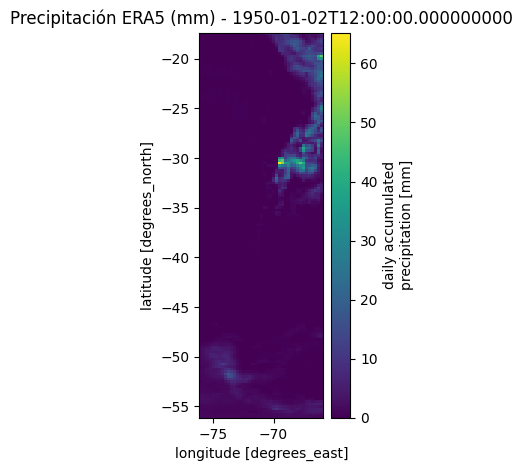

In [3]:
dia = str(ds['tp'].time.values[1])
ds['tp'].sel(time=dia).plot(figsize=(2,5))
plt.title(f"Precipitación ERA5 (mm) - {dia}")
plt.show()

In [4]:
import matplotlib.animation as animation
# === 2) Seleccionar rango de días (ejemplo: enero 1981) ===
tp_sel = ds['tp'].sel(time=slice("1981-05-01", "1981-05-20"))

# === 3) Crear figura ===
fig, ax = plt.subplots(figsize=(12,10))
cax = ax.imshow(tp_sel.isel(time=0), origin="lower")
title = ax.set_title(str(tp_sel.time.values[0])[:20])
plt.colorbar(cax, ax=ax, label="Precipitación (mm)")

# === 4) Función de actualización ===
def animate(i):
    data = tp_sel.isel(time=i)
    cax.set_array(data.values)
    title.set_text(str(data.time.values)[:20])
    return cax, title

# === 5) Crear animación ===
ani = animation.FuncAnimation(
    fig, animate, frames=len(tp_sel.time), interval=500, blit=False
)

plt.close(fig)  # para no mostrar imagen estática

# === 6) Mostrar en Jupyter (como HTML5 video) ===
from IPython.display import HTML
HTML(ani.to_jshtml())

# === 7) (Opcional) Guardar a mp4 ===
# ani.save("precipitacion_enero1981.mp4", writer="ffmpeg", dpi=150)

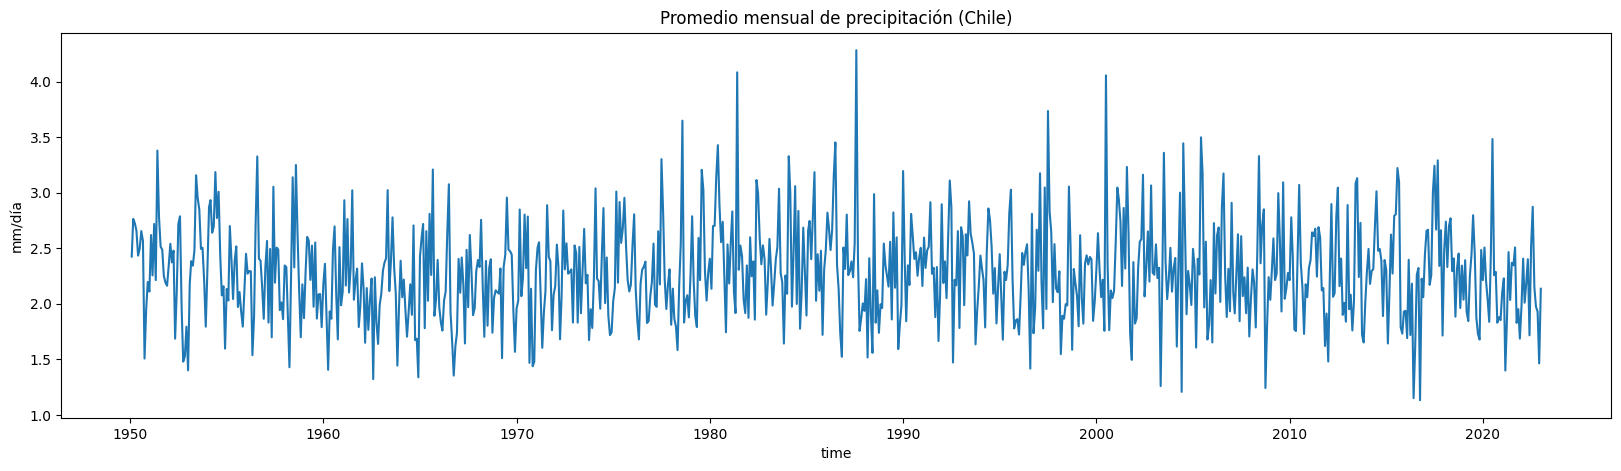

In [5]:
tp_monthly = ds['tp'].resample(time="ME").mean(dim="time")
tp_monthly.mean(dim=["latitude", "longitude"]).plot(figsize=(20,5))
plt.title("Promedio mensual de precipitación (Chile)")
plt.ylabel("mm/día")
plt.show()

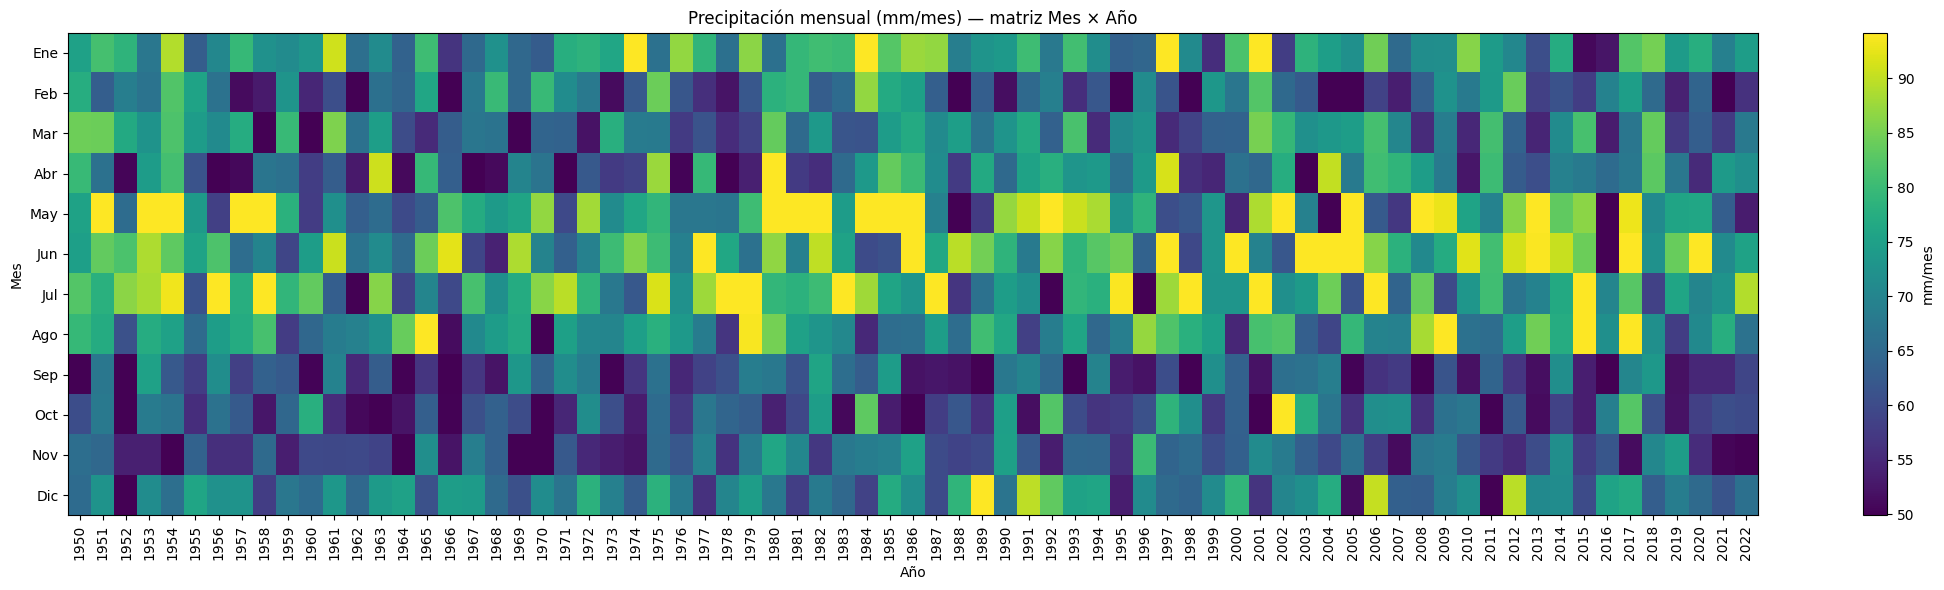

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

# --- 1) Prepara la matriz Mes x Año (como antes) ---
tp_monthly = ds['tp'].resample(time="ME").sum()
tp_monthly_mean = tp_monthly.mean(dim=["latitude", "longitude"])
df = tp_monthly_mean.to_dataframe().reset_index()
df["year"] = df["time"].dt.year
df["month"] = df["time"].dt.month
pivot = df.pivot(index="month", columns="year", values="tp").sort_index()

# --- 2) Elige normalización/colormap ---
MODE = "percentiles"   # "percentiles" | "log" | "power"

# Colormaps recomendados (perceptualmente uniformes)
cmap = "viridis"       # alterna: "cividis", "magma", "YlGnBu"

if MODE == "percentiles":
    # Escala robusta: ignora outliers usando percentiles
    vmin = np.nanpercentile(pivot.values, 5)
    vmax = np.nanpercentile(pivot.values, 95)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

elif MODE == "log":
    # Escala logarítmica: diferencia mejor años “normales” de extremos
    # Añade un epsilon para evitar log(0)
    eps = max(1e-2, np.nanpercentile(pivot.values, 1) * 0.01)
    norm = mcolors.LogNorm(vmin=eps, vmax=np.nanmax(pivot.values))

elif MODE == "power":
    # Potencia (gamma<1 expande bajos valores; gamma>1 los comprime)
    gamma = 0.5
    vmin = np.nanmin(pivot.values)
    vmax = np.nanmax(pivot.values)
    norm = mcolors.PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax)

# --- 3) Plot ---
plt.figure(figsize=(22, 6))
im = plt.imshow(pivot, aspect="auto", cmap=cmap, norm=norm, origin="upper")

# Ejes y etiquetas
plt.yticks(range(12), ["Ene","Feb","Mar","Abr","May","Jun",
                       "Jul","Ago","Sep","Oct","Nov","Dic"])
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
plt.xlabel("Año")
plt.ylabel("Mes")
plt.title("Precipitación mensual (mm/mes) — matriz Mes × Año")

# Colorbar con ticks amigables
cbar = plt.colorbar(im)
cbar.set_label("mm/mes")

plt.tight_layout()
plt.show()

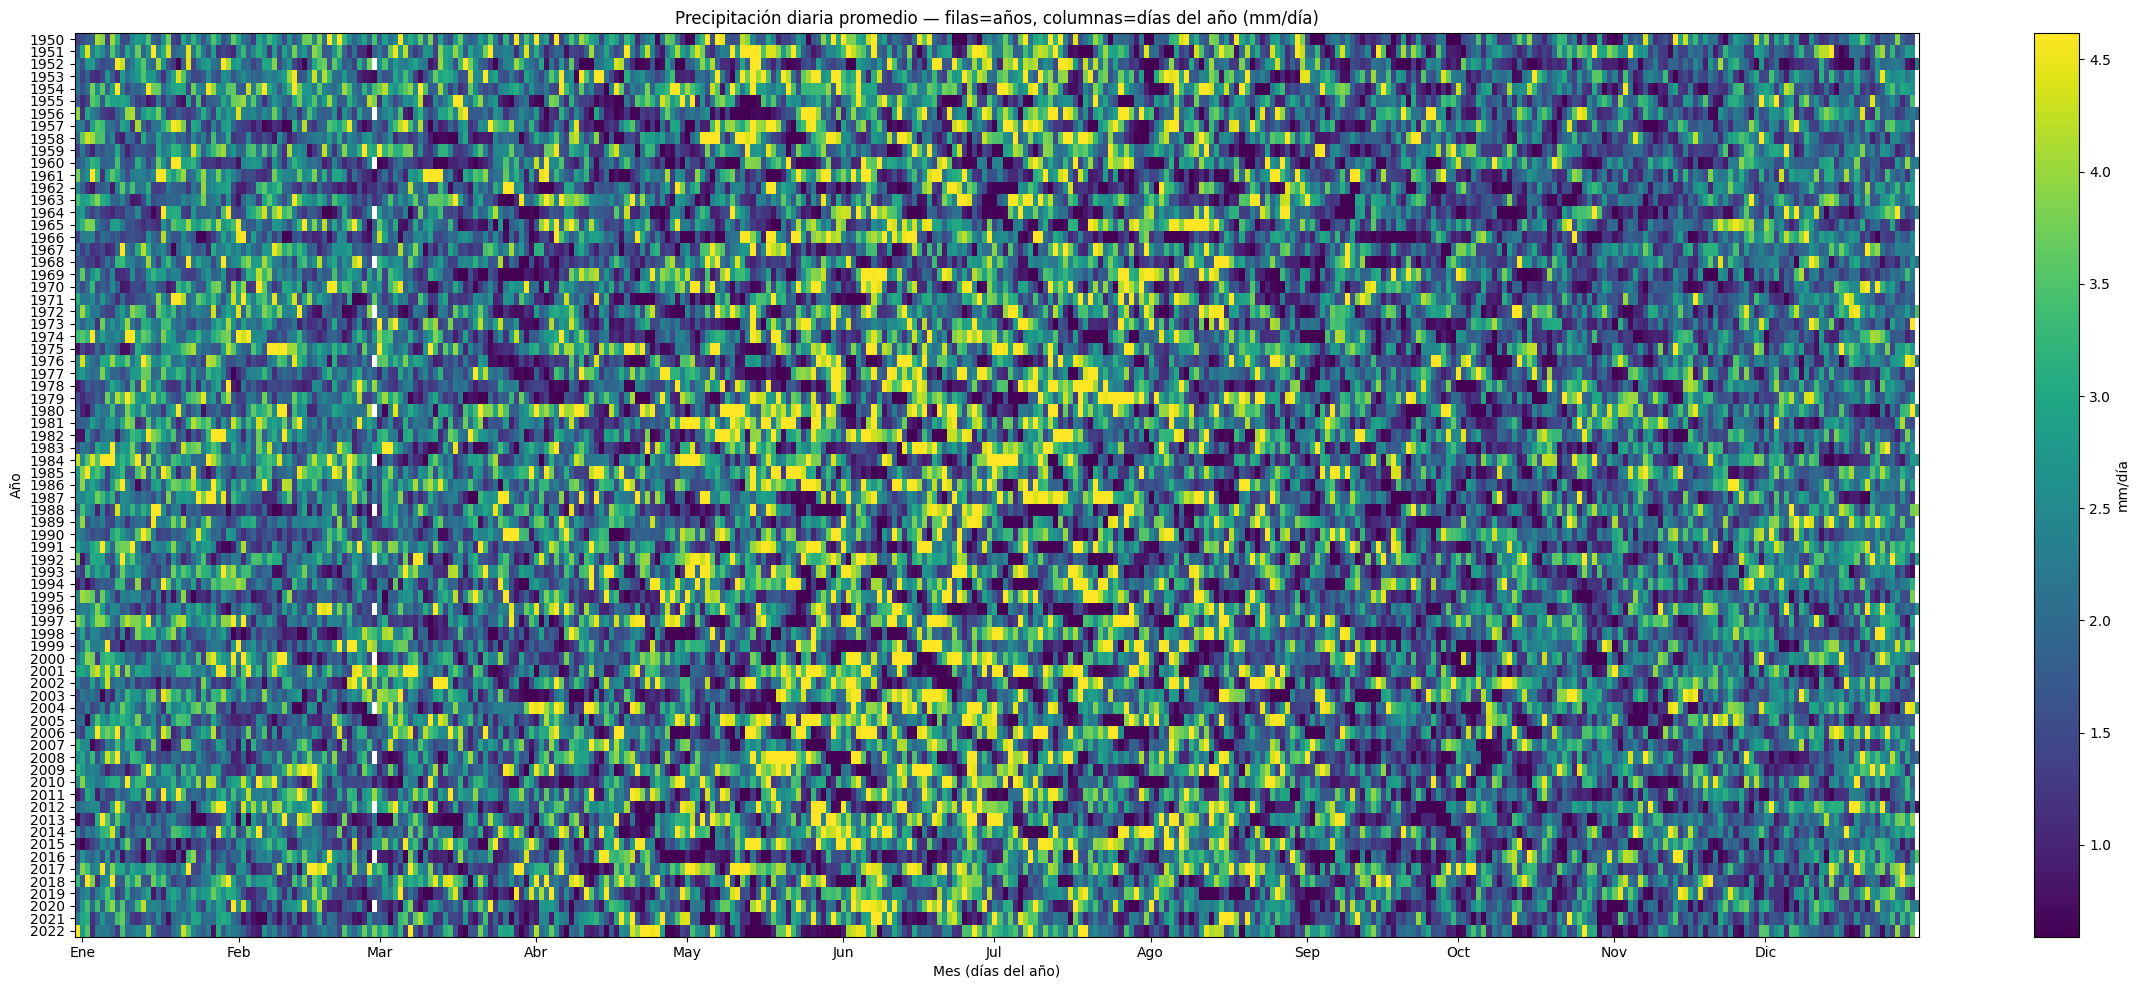

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr

# === 1) Cargar y preparar: diario (mm/día) promedio sobre Chile ===
# ajusta el nombre del archivo/variable según tu caso
#ds = xr.open_dataset("era5_tp_chile.nc")
tp_daily = ds["tp"].resample(time="1D").sum()
tp_daily_mean = tp_daily.mean(dim=["latitude", "longitude"])    # promedio espacial

# === 2) DataFrame con año y día-del-año (doy) ===
df = tp_daily_mean.to_dataframe(name="mm").reset_index()
# Opción: eliminar 29-Feb para matriz 365xAños
mask = ~((df["time"].dt.month == 2) & (df["time"].dt.day == 29))
df = df[mask]
df["year"] = df["time"].dt.year
df["doy"]  = df["time"].dt.dayofyear

# === 3) Pivot: filas=año, columnas=día del año (1..365) ===
pivot = df.pivot(index="year", columns="doy", values="mm").sort_index()

# === 4) Normalización robusta (colores útiles aunque haya años muy lluviosos) ===
vmin = np.nanpercentile(pivot.values, 5)
vmax = np.nanpercentile(pivot.values, 95)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = "viridis"  # prueba "cividis", "magma" si prefieres

# === 5) Ejes: marcas en inicio de mes (no-bisiesto) ===
month_starts = pd.date_range("2001-01-01", "2001-12-31", freq="MS") 
xticks = [d.dayofyear for d in month_starts]
xlabels = ["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"]

# === 6) Plot ===
plt.figure(figsize=(24, 10))
im = plt.imshow(pivot.values, aspect="auto", cmap=cmap, norm=norm, origin="upper")

# ticks: X = días, Y = años
plt.xticks(xticks, xlabels)
plt.yticks(range(pivot.shape[0]), pivot.index.tolist())
plt.xlabel("Mes (días del año)")
plt.ylabel("Año")
plt.title("Precipitación diaria promedio — filas=años, columnas=días del año (mm/día)")

cbar = plt.colorbar(im)
cbar.set_label("mm/día")
plt.tight_layout()
plt.show()


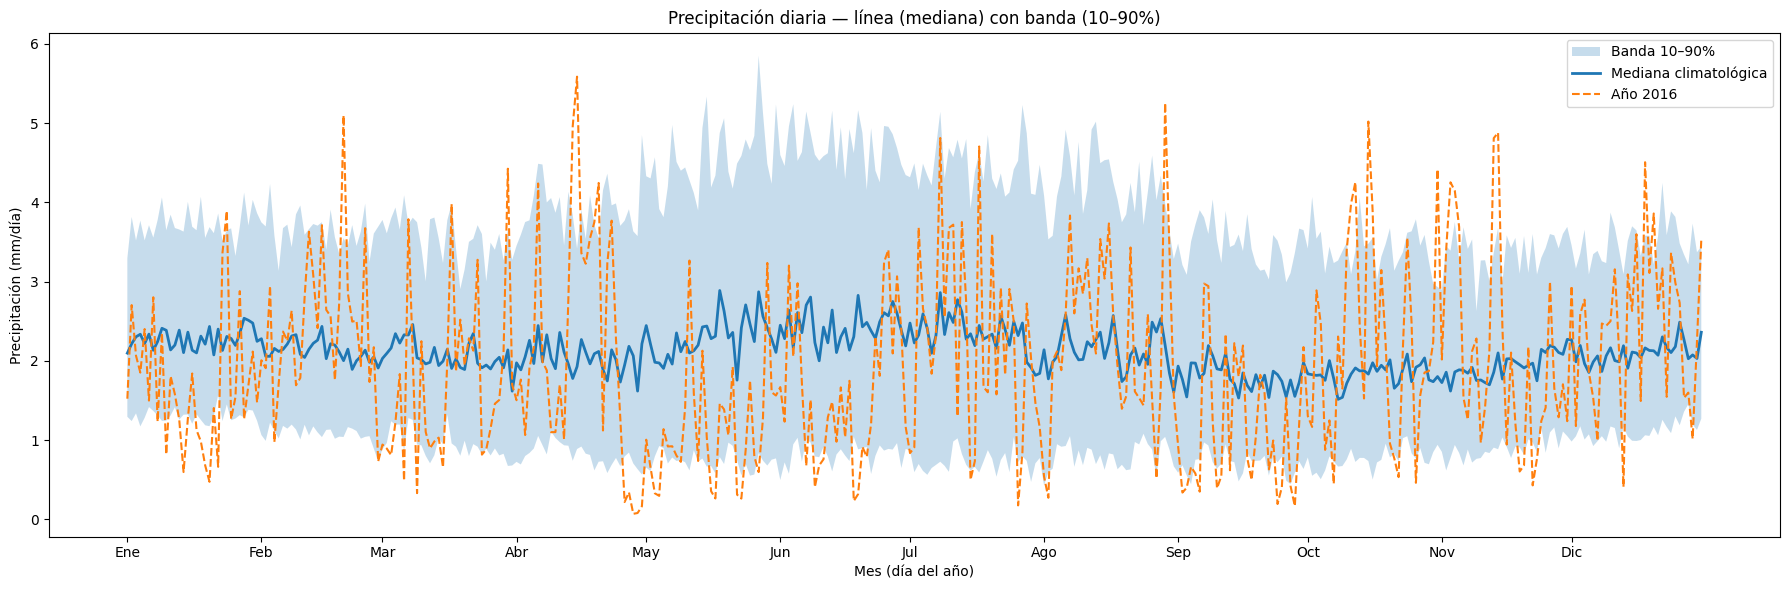

In [12]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1) Carga y serie diaria promedio sobre Chile ===
#ds = xr.open_dataset("era5_tp_chile.nc")
# si ya está diario en mm, omite el resample y el *1000
tp_daily_mm = ds["tp"].resample(time="1D").sum()
serie = tp_daily_mm.mean(dim=["latitude","longitude"])  # DataArray (time)

# === 2) DataFrame con año y mm-dd; quitamos 29-feb para matriz 365xAños ===
df = serie.to_dataframe(name="mm").reset_index()
df = df[~((df.time.dt.month==2) & (df.time.dt.day==29))]  # sin 29-feb
df["year"] = df.time.dt.year
df["mmdd"] = df.time.dt.strftime("%m-%d")                 # mes-día (string)

# orden de días del año (no bisiesto) para el eje X
ref = pd.date_range("2001-01-01","2001-12-31", freq="D")
order_mmdd = ref.strftime("%m-%d").tolist()
doy_index = np.arange(1, len(order_mmdd)+1)

# === 3) Climatología por día-del-año a través de los años ===
grp = df.groupby("mmdd")["mm"]
p10 = grp.quantile(0.10).reindex(order_mmdd).values
p50 = grp.quantile(0.50).reindex(order_mmdd).values  # mediana
p90 = grp.quantile(0.90).reindex(order_mmdd).values

# === 4) (Opcional) destacar un año particular encima de la banda ===
YEAR_TO_HIGHLIGHT = 2016   # cámbialo o pon None para no dibujar
if YEAR_TO_HIGHLIGHT is not None:
    df_y = df[df["year"]==YEAR_TO_HIGHLIGHT].set_index("mmdd").reindex(order_mmdd)
    y_line = df_y["mm"].values
else:
    y_line = None

# === 5) Ticks mensuales (no bisiesto) ===
month_starts = pd.date_range("2001-01-01","2001-12-31", freq="MS")
xticks = [d.dayofyear for d in month_starts]
xlabels = ["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"]

# === 6) Plot: banda 10–90 + mediana + (opcional) año destacado ===
plt.figure(figsize=(18,6))
plt.fill_between(doy_index, p10, p90, alpha=0.25, label="Banda 10–90%")
plt.plot(doy_index, p50, linewidth=2, label="Mediana climatológica")
if y_line is not None:
    plt.plot(doy_index, y_line, linewidth=1.5, linestyle="--",
             label=f"Año {YEAR_TO_HIGHLIGHT}")

plt.xticks(xticks, xlabels)
plt.xlabel("Mes (día del año)")
plt.ylabel("Precipitación (mm/día)")
plt.title("Precipitación diaria — línea (mediana) con banda (10–90%)")
plt.legend()
plt.tight_layout()
plt.show()


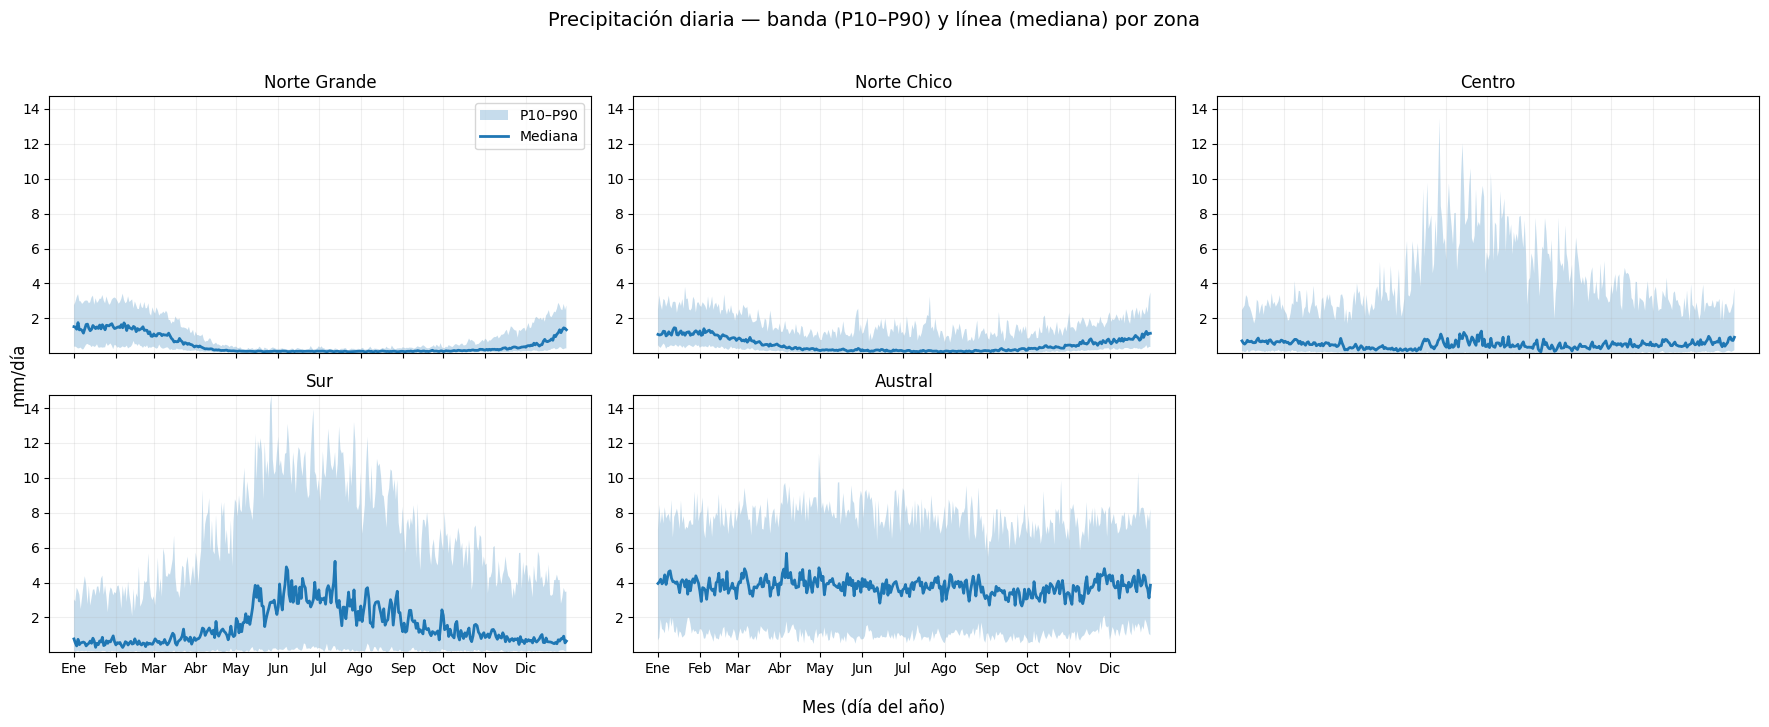

In [16]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== 1) Datos diarios en mm y orden de coords =====
# ds = xr.open_dataset("era5_tp_chile.nc")
tp_daily_mm = ds["tp"].resample(time="1D").sum()  # si ya está en mm/d, omite esto
if np.diff(tp_daily_mm.latitude.values).mean() < 0:
    tp_daily_mm = tp_daily_mm.sortby("latitude")
if tp_daily_mm.longitude.min() > 180:  # por si viene 0..360
    tp_daily_mm = tp_daily_mm.assign_coords(
        longitude=((tp_daily_mm.longitude + 180) % 360) - 180
    ).sortby("longitude")

# ===== 2) Zonas (lat_min, lat_max, lon_min, lon_max) =====
ZONAS = {
    "Norte Grande": (-24.5, -17.0, -76.0, -66.0),
    "Norte Chico":  (-32.0, -24.5, -76.0, -66.0),
    "Centro":       (-36.5, -32.0, -76.0, -66.0),
    "Sur":          (-43.5, -36.5, -76.0, -66.0),
    "Austral":      (-56.5, -43.5, -76.0, -66.0),
}

# ===== 3) Helper: promedio espacial (ponderado por área) y climatología con banda =====
def serie_diaria_zona(da, lat_min, lat_max, lon_min, lon_max, area_weight=True):
    sub = da.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
    if area_weight:
        w = np.cos(np.deg2rad(sub.latitude))
        s = sub.weighted(w).mean(dim=("latitude", "longitude"))
    else:
        s = sub.mean(dim=("latitude", "longitude"))
    return s  # DataArray 1D (time)

def climatologia_con_banda(serie):
    df = serie.to_dataframe(name="mm").reset_index()
    # quitar 29-feb para matriz 365xAños
    df = df[~((df.time.dt.month==2) & (df.time.dt.day==29))]
    df["mmdd"] = df.time.dt.strftime("%m-%d")
    grp = df.groupby("mmdd")["mm"]
    ref = pd.date_range("2001-01-01","2001-12-31",freq="D")  # no bisiesto
    order = ref.strftime("%m-%d").tolist()
    p10 = grp.quantile(0.10).reindex(order).values
    p50 = grp.quantile(0.50).reindex(order).values
    p90 = grp.quantile(0.90).reindex(order).values
    return p10, p50, p90

# ===== 4) Calcula curvas para cada zona =====
curvas = {}
for nombre, (lat_min, lat_max, lon_min, lon_max) in ZONAS.items():
    s = serie_diaria_zona(tp_daily_mm, lat_min, lat_max, lon_min, lon_max, area_weight=True)
    curvas[nombre] = climatologia_con_banda(s)

# Para ejes y comunes
all_p10 = np.concatenate([v[0] for v in curvas.values()])
all_p90 = np.concatenate([v[2] for v in curvas.values()])
ymin, ymax = np.nanmin(all_p10), np.nanmax(all_p90)

# X (día del año) y ticks mensuales
doy = np.arange(1, 366)
month_starts = pd.date_range("2001-01-01","2001-12-31", freq="MS")
xticks = [d.dayofyear for d in month_starts]
xlabels = ["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"]

# ===== 5) Plot en subplots =====
n = len(curvas)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3.5*nrows), sharex=True, sharey=False)
axes = np.atleast_1d(axes).ravel()

for ax, (nombre, (p10, p50, p90)) in zip(axes, curvas.items()):
    ax.fill_between(doy, p10, p90, alpha=0.25, label="P10–P90")
    ax.plot(doy, p50, lw=2, label="Mediana")
    ax.set_title(nombre)
    ax.set_ylim(ymin, ymax)
    ax.set_xticks(xticks, xlabels, rotation=0)
    ax.grid(True, alpha=0.2)

# leyenda solo una vez
axes[0].legend()
for ax in axes[n:]:
    ax.remove()

fig.suptitle("Precipitación diaria — banda (P10–P90) y línea (mediana) por zona", y=1.02, fontsize=14)
fig.supxlabel("Mes (día del año)")
fig.supylabel("mm/día")
fig.tight_layout()
plt.show()


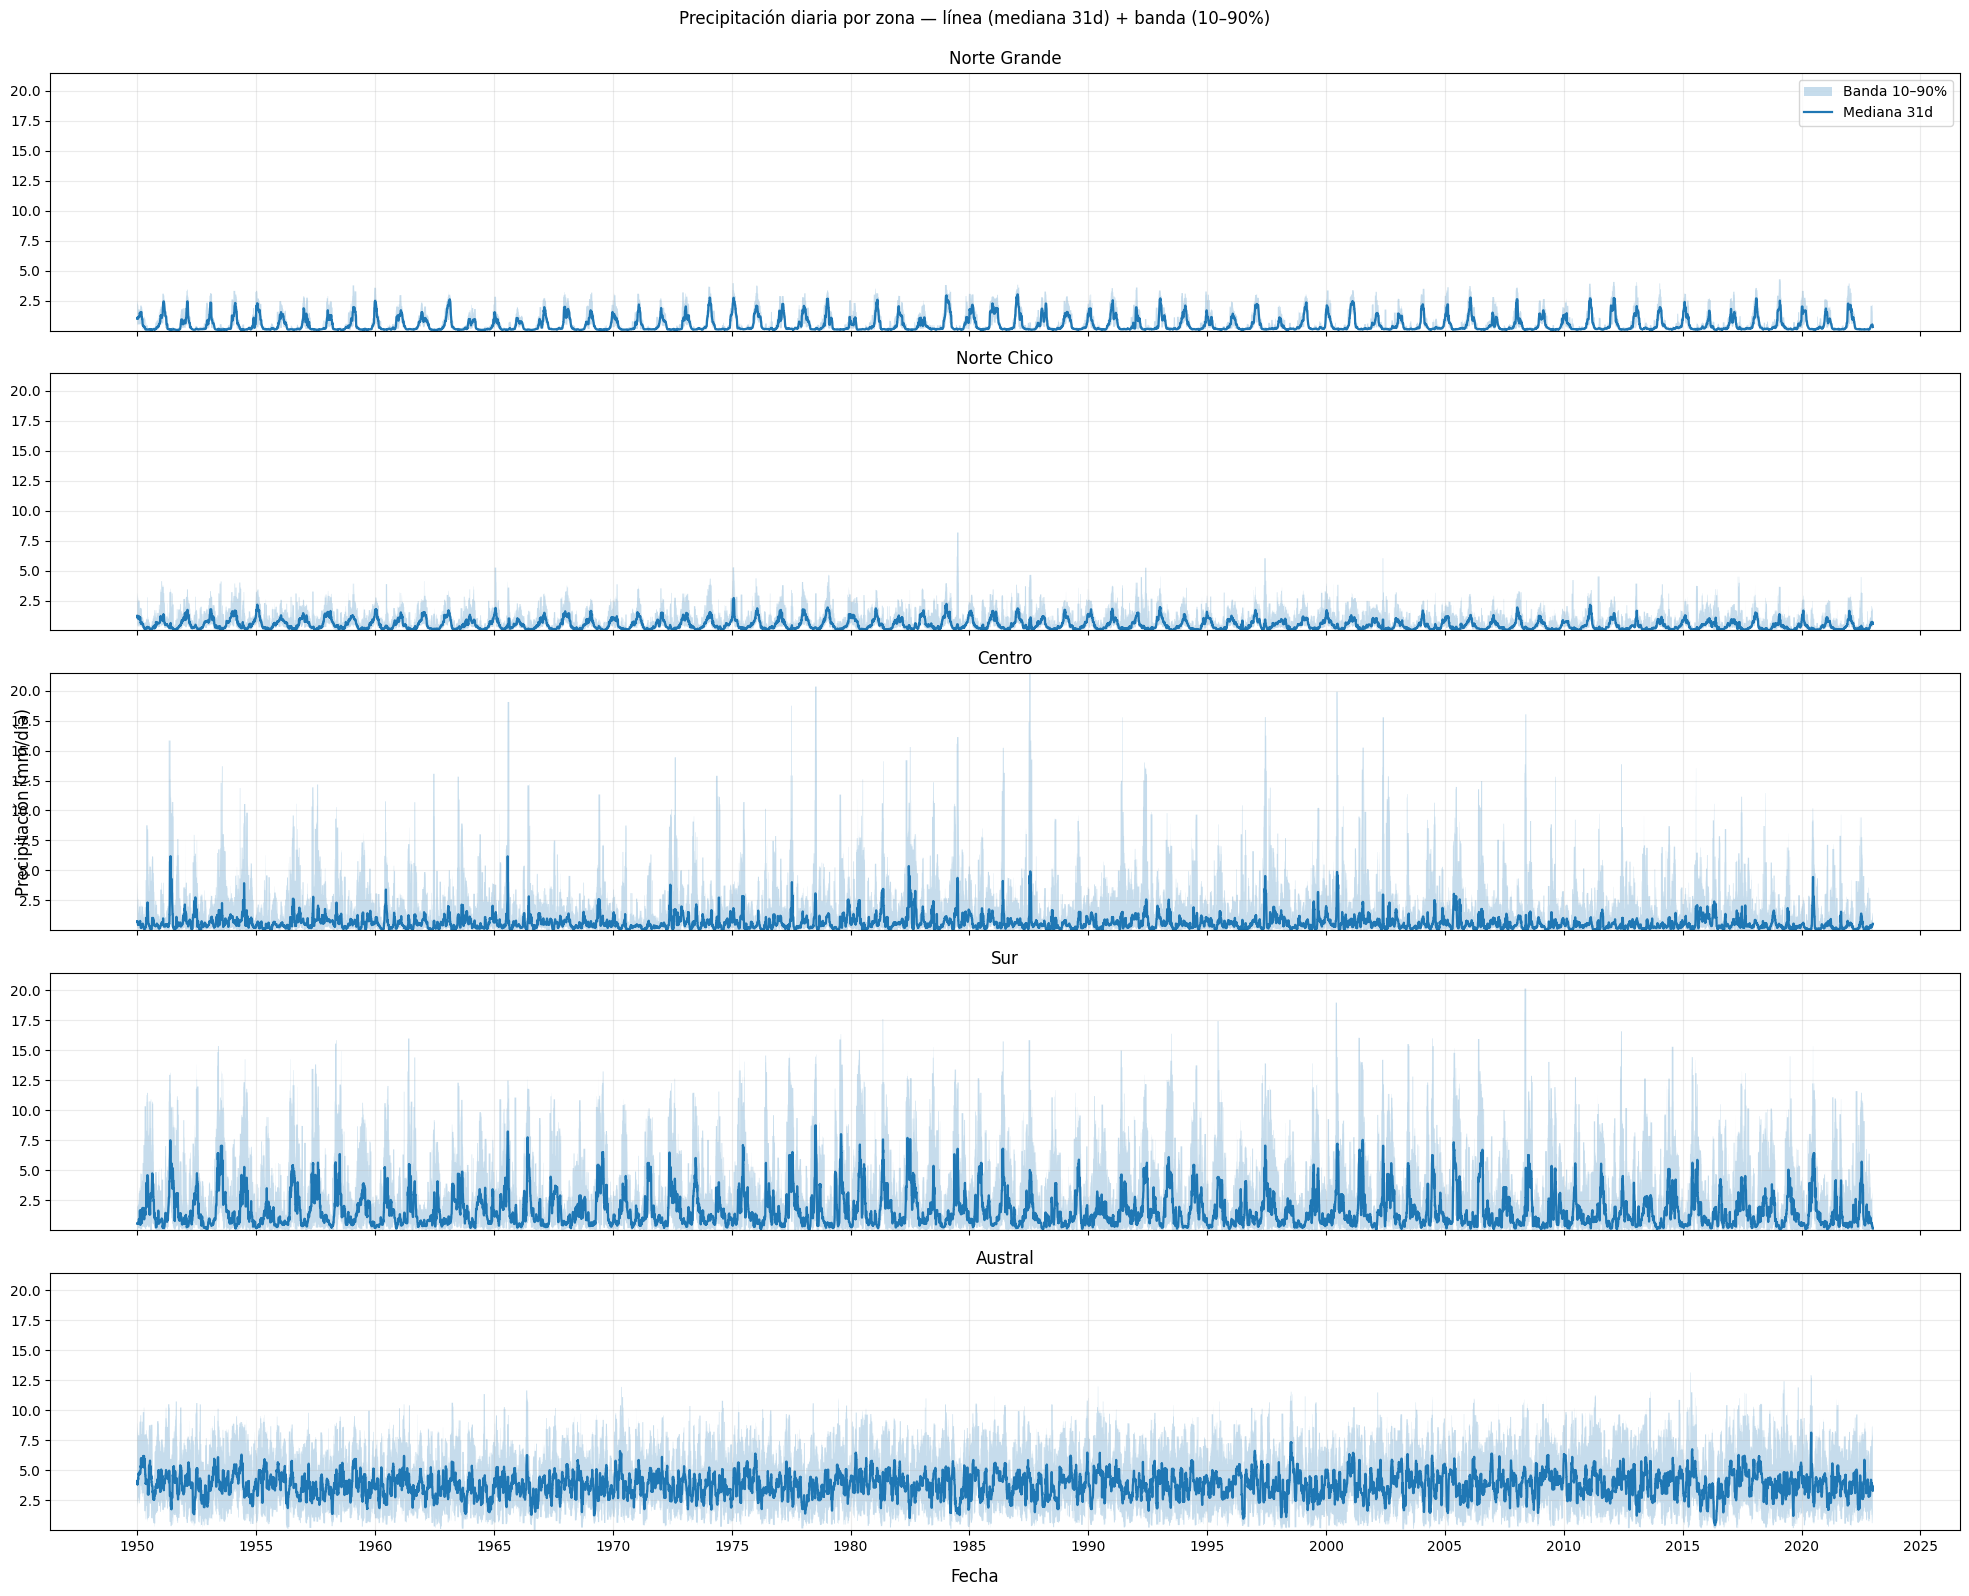

In [19]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ===== Config =====
PATH = "era5_tp_chile.nc"
VAR  = "tp"           # precipitación ERA5
WIN  = 31             # ventana para mediana/banda (días)
QLOW, QHIGH = 0.10, 0.90

# Zonas (lat_min, lat_max, lon_min, lon_max)
ZONAS = {
    "Norte Grande": (-24.5, -17.0, -76.0, -66.0),
    "Norte Chico":  (-32.0, -24.5, -76.0, -66.0),
    "Centro":       (-36.5, -32.0, -76.0, -66.0),
    "Sur":          (-43.5, -36.5, -76.0, -66.0),
    "Austral":      (-56.5, -43.5, -76.0, -66.0),
}

# ===== 1) Datos diarios (mm/día) =====
#ds = xr.open_dataset(PATH)
tp = ds[VAR].resample(time="1D").sum()   # m -> mm/día

# ordenar coords (por si acaso)
if np.diff(tp.latitude.values).mean() < 0:
    tp = tp.sortby("latitude")
if tp.longitude.min() > 180:
    tp = tp.assign_coords(longitude=((tp.longitude + 180) % 360) - 180).sortby("longitude")

# ===== 2) Helpers =====
def serie_diaria_zona(da, lat_min, lat_max, lon_min, lon_max, area_weight=True):
    sub = da.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
    if area_weight:
        w = np.cos(np.deg2rad(sub.latitude))
        ser = sub.weighted(w).mean(("latitude","longitude"))
    else:
        ser = sub.mean(("latitude","longitude"))
    return ser  # DataArray(time)

def curva_banda_moviles(ser, win=WIN, qlow=QLOW, qhigh=QHIGH):
    s = ser.to_series().asfreq("D")
    # si hay huecos y quieres continuidad, descomenta:
    # s = s.interpolate(limit_direction="both")
    med = s.rolling(win, center=True, min_periods=win//2).median()
    lo  = s.rolling(win, center=True, min_periods=win//2).quantile(qlow)
    hi  = s.rolling(win, center=True, min_periods=win//2).quantile(qhigh)
    return med, lo, hi

# ===== 3) Curvas por zona =====
curvas = {}
for nombre, (la_min, la_max, lo_min, lo_max) in ZONAS.items():
    ser = serie_diaria_zona(tp, la_min, la_max, lo_min, lo_max, area_weight=True)
    med, lo, hi = curva_banda_moviles(ser, WIN, QLOW, QHIGH)
    curvas[nombre] = (med, lo, hi)

# Escala Y común
all_lo = pd.concat([v[1] for v in curvas.values()])
all_hi = pd.concat([v[2] for v in curvas.values()])
ymin, ymax = float(np.nanmin(all_lo.values)), float(np.nanmax(all_hi.values))

# Locator de años (ajuste automático según rango)
all_index = pd.concat([v[0] for v in curvas.values()]).index
n_years = all_index[-1].year - all_index[0].year + 1
base = 1 if n_years <= 8 else (2 if n_years <= 16 else 5)

# ===== 4) Plot vertical =====
n = len(curvas)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(20, 3.2*n), sharex=True, sharey=True)
axes = np.atleast_1d(axes)

for ax, (nombre, (med, lo, hi)) in zip(axes, curvas.items()):
    ax.fill_between(med.index, lo, hi, alpha=0.25, label=f"Banda {int(QLOW*100)}–{int(QHIGH*100)}%")
    ax.plot(med.index, med, lw=1.6, label=f"Mediana {WIN}d")
    ax.set_title(nombre)
    ax.set_ylim(ymin, ymax)
    ax.grid(True, alpha=0.25)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=base))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# leyenda solo en el primero
axes[0].legend(loc="upper right")
fig.supxlabel("Fecha")
fig.supylabel("Precipitación (mm/día)")
fig.suptitle(f"Precipitación diaria por zona — línea (mediana {WIN}d) + banda ({int(QLOW*100)}–{int(QHIGH*100)}%)", y=0.995)
fig.tight_layout()
plt.show()
